In [1]:
import hashlib
import random

# https://neuromancer.sk/std/nist/P-256
# https://datatracker.ietf.org/doc/html/rfc6979#page-33

In [2]:
#q=int('FFFFFFFF00000000FFFFFFFFFFFFFFFFBCE6FAADA7179E84F3B9CAC2FC632551',16)
q=int(0xffffffff00000001000000000000000000000000ffffffffffffffffffffffff)
a=int(0xffffffff00000001000000000000000000000000fffffffffffffffffffffffc)
b=int(0x5ac635d8aa3a93e7b3ebbd55769886bc651d06b0cc53b0f63bce3c3e27d2604b)
Px=int(0x6b17d1f2e12c4247f8bce6e563a440f277037d812deb33a0f4a13945d898c296)
Py=int(0x4fe342e2fe1a7f9b8ee7eb4a7c0f9e162bce33576b315ececbb6406837bf51f5)
n=int(0xffffffff00000000ffffffffffffffffbce6faada7179e84f3b9cac2fc632551)
#d=int('C9AFA9D845BA75166B5C215767B1D6934E50C3DB36E89B127B8A622B120F6721',16)
#k=int('A6E3C57DD01ABE90086538398355DD4C3B17AA873382B0F24D6129493D8AAD60',16)
m='sample'

In [3]:
def modinverse_(w,c):#w es el número que se desea invertir; c es el módulo
    x = pow(w,c-2,c)
    return x

In [4]:
def verify_():
    cond=(4*a**3+27*b**2)%q
    if cond!=0:
        exist=True
    else:
        exist=False
    return exist

In [5]:
def sum_(Px,Py,Qx,Qy):
    lambd=((Qy-Py)*modinverse_(Qx-Px,q))%q
    Rx=(lambd**2-Px-Qx)%q
    Ry=(-Py+lambd*(Px-Rx))%q
    return Rx,Ry

In [6]:
def duplicate_(Px,Py):
    lambd=((3*(Px**2)+a)*modinverse_(2*Py,q))%q
    Qx=(lambd**2-2*Px)%q
    Qy=(-Py+lambd*(Px-Qx))%q
    return Qx,Qy

In [7]:
def binaryscalarproduct_(Px,Py,k):
    kbin=bin(k)[2:]
    #print('kbin:', kbin)
    m=len(kbin)
    #print(m)
    Qx=Px
    Qy=Py
    #for j in range(m-2,-1,-1):
    for j in range(1,m,1):
        #print('Secuencia: ',j,' Bit: ',kbin[j])
        Qx,Qy=duplicate_(Qx,Qy)
        #print('duplicado:',Qx,Qy)
        if kbin[j]=='1':
            Qx,Qy=sum_(Qx,Qy,Px,Py)
            #print('sumado:',Qx,Qy)
    return Qx,Qy

In [9]:
def generatesignature_(Px,Py,n,d,m):
    r=0
    s=0
    while r==0 or s==0:
        k=random.randint(0,n-1) #para fines de esta implementación, k se da en los vectores de prueba.
        Qx,Qy=binaryscalarproduct_(Px,Py,k)
        r=Qx%n
        e=hashlib.sha256()
        e.update(m.encode('utf-8'))
        e=int(e.hexdigest(),16)
        j=modinverse_(k,n)%n
        s=(j*(e+d*r))%n
    return r,s

In [11]:
def generatePrivateKey_(n):
    d = random.randint(1,n-1)
    return d

In [12]:
def generatePublicKey_(Px,Py,d):
    Dx,Dy=binaryscalarproduct_(Px,Py,d)
    return Dx,Dy

In [13]:
def verifysignature_(Px,Py,n,Dx,Dy,m,r,s):
    if (r<=0 or r>=(n-1) or s<=0 or s>=(n-1)):
        final=False
    else:
        w=modinverse_(s,n)%n
        u=hashlib.sha256()
        u.update(m.encode('utf-8'))
        u=int(u.hexdigest(),16)
        u1=(w*u)%n
        u2=(r*w)%n
        u1_times_Px,u1_times_Py=binaryscalarproduct_(Px,Py,u1)
        u2_times_Dx,u2_times_Dy=binaryscalarproduct_(Dx,Dy,u2)
        Yx,Yy=sum_(u1_times_Px,u1_times_Py,u2_times_Dx,u2_times_Dy)
        v=Yx%n
        if (r==v):
            final=True
        else:
            final=False
    return final

In [21]:
test_vectors = []
vectors_num = 100
tiempo_gen_llaves = []
tiempo_gen_firma = []
tiempo = []
tiempo_val_firma = []
import time

for i in range(vectors_num):
    start_time_process = time.time()
    
    start_time = time.time()
    d = generatePrivateKey_(n)
    Dx,Dy = generatePublicKey_(Px,Py,d)
    tiempo_computo = time.time() - start_time
    tiempo_gen_llaves.append(tiempo_computo)
    
    start_time = time.time()
    r,s = generatesignature_(Px,Py,n,d,m)
    tiempo_computo = time.time() - start_time
    tiempo_gen_firma.append(tiempo_computo)
    
    start_time = time.time()
    result = verifysignature_(Px,Py,n,Dx,Dy,m,r,s)
    tiempo_computo = time.time() - start_time
    tiempo_val_firma.append(tiempo_computo)
    
    tiempo_total = time.time() - start_time_process
    tiempo.append(tiempo_total)
    
    list_aux = [d,Dx,Dy,r,s,tiempo_total,result]
    
    test_vectors.append(list_aux)

In [22]:
labels = ['Llave Privada: ','Llave Publica Dx: ','Llave Publica Dy: ','Firma Digital r: ','Firma Digital s: ', 'Tiempo de Cómputo: ', 'Resultado: ']
with open('vectores_prueba.txt', 'w', encoding='utf-8') as f:
    for i in range(len(test_vectors)):
        f.write('Vector de Prueba: '+str(i+1)+'\n')
        for j in range(7):
            f.write(labels[j]+str(test_vectors[i][j])+'\n')
            #print(labels[j],test_vectors[i][j])
        f.write('\n')   

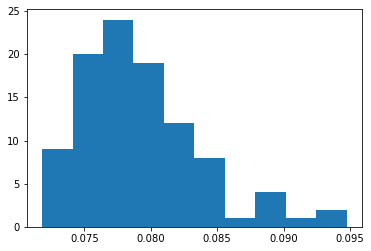

In [23]:
import matplotlib.pyplot as plt
plt.hist(tiempo_gen_llaves)
plt.show()

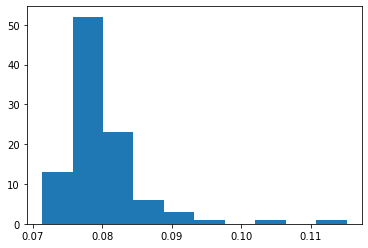

In [24]:
plt.hist(tiempo_gen_firma)
plt.show()

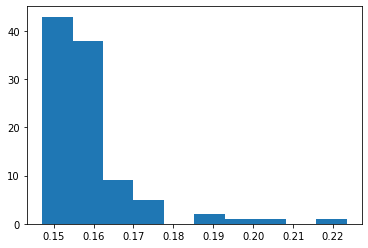

In [27]:
plt.hist(tiempo_val_firma)
plt.show()

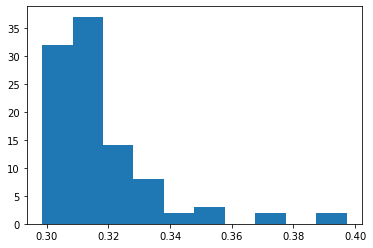

In [26]:
plt.hist(tiempo)
plt.show()